# **Notebook for Home Price Predictions** #


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml/blob/master/01_the_machine_learning_landscape.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## **Setup**

In [1]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [5]:
%cd drive/MyDrive/kaggle-home-prices/

[Errno 2] No such file or directory: 'drive/MyDrive/kaggle-home-prices/'
/content/drive/MyDrive/kaggle-home-prices


In [62]:
import numpy as np # linear algebra
import pandas as pd 

test_set = pd.DataFrame()
train_set = pd.DataFrame()
import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        if filename == "test.csv":
            test_set = pd.read_csv(os.path.join(dirname, filename))
        if filename == "train.csv":
            train_set = pd.read_csv(os.path.join(dirname, filename))    
        print(os.path.join(dirname, filename))


data/data_description.txt
data/sample_submission.csv
data/test.csv
data/train.csv


In [40]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_set, test_size=0.2, random_state=42)

In [41]:
print(train.head())
print(train.info())
print(train.describe())

        Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
254    255          20       RL  ...        WD         Normal    145000
1066  1067          60       RL  ...        WD         Normal    178000
638    639          30       RL  ...        WD         Normal     85000
799    800          50       RL  ...        WD         Normal    175000
380    381          50       RL  ...        WD         Normal    127000

[5 rows x 81 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 254 to 1126
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    951 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          74 non-null     object 
 7   LotShape       1168 non-null   obje

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50,figsize=(20,15))
plt.show()

In [20]:
corr_matrix = train.corr()
new_obj = corr_matrix["SalePrice"].sort_values(ascending=False)
print(new_obj)

SalePrice        1.000000
OverallQual      0.785555
GrLivArea        0.695652
GarageCars       0.640991
GarageArea       0.624139
TotalBsmtSF      0.597766
1stFlrSF         0.587883
FullBath         0.552546
TotRmsAbvGrd     0.520388
YearBuilt        0.516501
YearRemodAdd     0.508593
GarageYrBlt      0.480351
MasVnrArea       0.459123
Fireplaces       0.457549
BsmtFinSF1       0.359460
LotFrontage      0.330066
WoodDeckSF       0.329843
2ndFlrSF         0.314030
OpenPorchSF      0.299969
HalfBath         0.280481
LotArea          0.266204
BsmtFullBath     0.226346
BsmtUnfSF        0.222487
BedroomAbvGr     0.156211
ScreenPorch      0.119172
PoolArea         0.115630
3SsnPorch        0.051532
MoSold           0.041890
BsmtFinSF2      -0.005731
YrSold          -0.009099
LowQualFinSF    -0.011189
Id              -0.019643
MiscVal         -0.020179
BsmtHalfBath    -0.048346
OverallCond     -0.074391
MSSubClass      -0.088081
KitchenAbvGr    -0.142785
EnclosedPorch   -0.149532
Name: SalePr

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf5a6b150>,
      dtype=object)

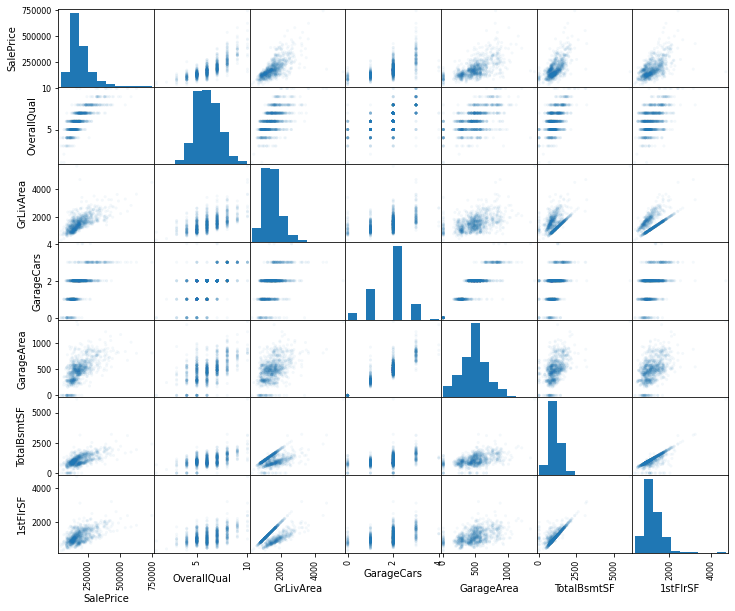

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(train[["SalePrice", "OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF", "1stFlrSF"]], figsize=(12,10),alpha=0.05)

In [ ]:
keys = corr_matrix["SalePrice"].sort_values(ascending=False).keys()
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
split_keys = list(chunks(keys, 5))
count = 0
for key_list in split_keys:
  if count == 0:
    count += 1
    continue  
  new_keys = key_list.append(pd.Index(["SalePrice"]))
  print(new_keys)
  scatter_matrix(train[new_keys], figsize=(12,10),alpha=0.05)


In [ ]:


# encoder = LabelBinarizer()
# train_cat_1hot = endcoder.fit_transform(train_cat.reshape(-1,1))

# **Transformers**

In [63]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor




class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self  
  def transform(self, X):
    return X[self.attribute_names].values  

labels = train["SalePrice"].copy()
new_train = train.drop("SalePrice", axis=1)

num_attribs = list(new_train.select_dtypes(exclude='object').keys())
cat_attribs = list(new_train.select_dtypes(include='object').keys())
print(num_attribs)
print(cat_attribs)

num_pipeline= Pipeline([('selector', DataFrameSelector(num_attribs)), ('imputer', SimpleImputer(strategy='median')), ('std_scaler', StandardScaler()), ('feature_selector', SelectFromModel(RandomForestRegressor(), threshold=-np.inf, max_features=10)), ])
cat_pipeline= Pipeline([('selector', DataFrameSelector(cat_attribs)), ('imputer', CategoricalImputer()), ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),])

full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline), ("cat_pipeline", cat_pipeline),])

train_prepared = full_pipeline.fit_transform(new_train, labels)
 


['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'Gar

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': [2,4,6,8]},
              {'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_prepared, labels)

feature_importances = grid_search.best_estimator_.feature_importances_
lin_reg = grid_search.best_estimator_

print(test.head())

test_prepared = full_pipeline.transform(test)
predictions = lin_reg.predict(test_prepared)
print(predictions[:5])


import csv

# # open the file in the write mode
# f = open('submission.csv', 'w')
# writer = csv.writer(f)

# # write a row to the csv file
# writer.writerow(["Id", "SalePrice"])
# for count, id in enumerate(test["Id"]):
#    writer.writerow([id, predictions[count]])

# close the file
#f.close()   
from sklearn.metrics import mean_squared_error
test_labels = test["SalePrice"].copy()
lin_mse = mean_squared_error(test_labels, predictions)
lin_rmse = np.sqrt(lin_mse)
for i, p in enumerate(test["SalePrice"]):
  print(predictions[i], p)
print(lin_rmse)

l = np.sort(feature_importances)
print(l)


        Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
892    893          20       RL  ...        WD         Normal    154500
1105  1106          60       RL  ...        WD         Normal    325000
413    414          30       RM  ...        WD         Normal    115000
522    523          50       RM  ...        WD         Normal    159000
1036  1037          20       RL  ...        WD         Normal    315500

[5 rows x 81 columns]
[140448.33333333 336558.26666667 126385.83333333 137130.
 348462.63333333]
140448.33333333334 154500
336558.26666666666 325000
126385.83333333333 115000
137130.0 159000
348462.63333333336 315500
104516.66666666667 75500
195296.66666666666 311500
151238.33333333334 146000
93050.0 84500
137262.13333333333 135500
144612.9 145000
118296.1 130000
146310.0 81000
218941.33333333334 214000
177329.5 181000
129416.66666666667 134500
191368.0 183500
143876.66666666666 135000
147906.66666666666 118400
212008.33333333334 226000
155326.66666666666 15500

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

train_set_labels = train_set["SalePrice"].copy()
new_train = train_set.drop("SalePrice", axis=1)
train_set_prepared = full_pipeline.fit_transform(train_set, train_set_labels)


param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': [2,4,6,8]},
              {'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_set_prepared, train_set_labels)

feature_importances = grid_search.best_estimator_.feature_importances_
lin_reg = grid_search.best_estimator_

print(test.head())

test_set_prepared = full_pipeline.transform(test_set)
final_predictions = lin_reg.predict(test_set_prepared)

print(final_predictions)


import csv

# open the file in the write mode
f = open('submission.csv', 'w')
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(["Id", "SalePrice"])
for count, id in enumerate(test_set["Id"]):
   writer.writerow([id, final_predictions[count]])


# close the file
f.close()   

        Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
892    893          20       RL  ...        WD         Normal    154500
1105  1106          60       RL  ...        WD         Normal    325000
413    414          30       RM  ...        WD         Normal    115000
522    523          50       RM  ...        WD         Normal    159000
1036  1037          20       RL  ...        WD         Normal    315500

[5 rows x 81 columns]
[133240.         158071.66666667 180696.66666667 ... 141891.66666667
 118430.3        228316.66666667]
